In [1]:
'''
This is used for generate dynamic_np before training. Then we use this np file in our adapt method
'''
import sys
sys.path.append('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/skin-lesion-segmentation-transformer')
from Datasets.create_dataset import norm01, Dataset_wrap_csv
import torch
import numpy as np
import pandas as pd
import os
import torchvision
import random
import h5py
from tqdm import tqdm
import timm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
exp_name = 'N34'
model_name = 'FATNet_adapt'

dataset_list = ['isic2018', 'PH2', 'DMF', 'SKD']
train_loaders = {}
test_loaders = {}
for dataset_name in dataset_list:
    datas = Dataset_wrap_csv(k_fold='No', use_old_split=True, img_size=224, 
        dataset_name = dataset_name, split_ratio=[0.8,0.2], 
        train_aug=False)
    train_data = datas['train']
    test_data = datas['test']
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=16,
                                            shuffle=False,
                                            num_workers=2,
                                            pin_memory=True,
                                            drop_last=False)
    test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=16,
                                            shuffle=False,
                                            num_workers=2,
                                            pin_memory=True,
                                            drop_last=False)
    train_loaders[dataset_name] = train_loader
    test_loaders[dataset_name] = test_loader
    print('{} has {} training samples, {} test samples'.format(dataset_name, len(train_loader.dataset), len(test_loader.dataset)))

isic2018 has 2594 samples, 2075 are used to train, 519 are used to test. 
 The split ratio is [0.8, 0.2]
isic2018 has 2075 training samples, 519 test samples
PH2 has 200 samples, 160 are used to train, 40 are used to test. 
 The split ratio is [0.8, 0.2]
PH2 has 160 training samples, 40 test samples
DMF has 1212 samples, 969 are used to train, 243 are used to test. 
 The split ratio is [0.8, 0.2]
DMF has 969 training samples, 243 test samples
SKD has 206 samples, 164 are used to train, 42 are used to test. 
 The split ratio is [0.8, 0.2]
SKD has 164 training samples, 42 test samples


In [6]:
if model_name == 'resnet':
    network = torchvision.models.resnet101(pretrained=True)
    network = torch.nn.Sequential(*list(network.children())[:-1])
    # coat
elif model_name == 'coat':
    network = timm.create_model('coat_lite_small', pretrained=True) 
elif model_name == 'FATNet':
    from Models.Transformer.UFAT import FATNet  
    network = FATNet(drop_rate=0.1, drop_path_rate=0.1, conv_norm=torch.nn.BatchNorm2d)
    network.load_state_dict(torch.load('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/results/'+
    'K_results/{}/ca_four_fold4_FATNet_20221111_1917/best.pth'.format(exp_name)))
elif model_name == 'FATNet_adapt':
    from Models.Transformer.UFAT_for_adapt import FATNet_adapt
    network = FATNet_adapt(img_size=256, drop_rate=0.1, drop_path_rate=0.1,
        conv_norm=torch.nn.BatchNorm2d, adapt_method='Sup', num_domains=4, 
        feature_dim=512, do_detach=False)
    network.load_state_dict(torch.load('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/results/'+
    'N_results/{}/ca_SupDo_fold4_FATNet_adapt_20221208_1858/best.pth'.format(exp_name))) 
network.cuda()
network.eval()

FATNet_adapt(
  (stem): Sequential(
    (0): Conv2d_BN(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_layer): Hardswish()
    )
    (1): Conv2d_BN(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_layer): Hardswish()
    )
  )
  (patch_embed_stages): ModuleList(
    (0): DWCPatchEmbed(
      (patch_conv): DWConv2d_BN(
        (dwconv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pwconv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Hardswish()
      )
    )
    (1): DWCPatchEmbed(
      (patch_conv): DWConv2d_BN(
       

In [7]:
data_folder = '/bigdata/siyiplace/data/skin_lesion'
train_features = []
train_dataset_id_list = []
train_four_id_list = []
for dataset_name in ['isic2018','PH2','DMF','SKD']:
    loader = train_loaders[dataset_name]
    for batch in tqdm(loader):
        img = batch['image'].cuda().float()
        diagnosis = batch['diagnosis_id']
        dataset_id = batch['set_id']
        DC_id = batch['DC_id']
        four_id = batch['four_id']
        with torch.no_grad():
            # resnet
            if model_name == 'resnet':
                output = network(img)
                output = output.view(output.size(0), -1).cpu().numpy()
            # coat
            elif model_name == 'coat':
                output = network.forward_features(img)
                output = output[:,0].cpu().numpy()
            elif model_name == 'FATNet':
                output = network(img,out_feat=True,out_seg=False)
                output = output['feat'].cpu().numpy()
            elif model_name == 'FATNet_adapt':
                domain_label = batch['set_id']
                domain_label_oh = torch.nn.functional.one_hot(domain_label, 4).float().cuda()
                output = network(img,domain_label_oh,out_feat=True,out_seg=False)
                output = output['feat'].cpu().numpy()
            train_features.append(output)
            train_dataset_id_list.extend(dataset_id)
            train_four_id_list.extend(four_id)
train_features = np.concatenate(train_features, axis=0)
print(train_features.shape, len(train_dataset_id_list), len(train_four_id_list))

100%|██████████| 11/11 [00:00<00:00, 23.19it/s]

(3368, 512) 3368 3368


In [8]:
test_features = []
test_dataset_id_list = []
test_four_id_list = []
for dataset_name in ['isic2018','PH2','DMF','SKD']:
    loader = test_loaders[dataset_name]
    for batch in tqdm(loader):
        img = batch['image'].cuda().float()
        diagnosis = batch['diagnosis_id']
        dataset_id = batch['set_id']
        DC_id = batch['DC_id']
        four_id = batch['four_id']
        with torch.no_grad():
            # resnet
            if model_name == 'resnet':
                output = network(img)
                output = output.view(output.size(0), -1).cpu().numpy()
            # coat
            elif model_name == 'coat':
                output = network.forward_features(img)
                output = output[:,0].cpu().numpy()
            elif model_name == 'FATNet':
                output = network(img,out_feat=True,out_seg=False)
                output = output['feat'].cpu().numpy()
            elif model_name == 'FATNet_adapt':
                domain_label = batch['set_id']
                domain_label_oh = torch.nn.functional.one_hot(domain_label, 4).float().cuda()
                output = network(img,domain_label_oh,out_feat=True,out_seg=False)
                output = output['feat'].cpu().numpy()
            test_features.append(output)
            test_dataset_id_list.extend(dataset_id)
            test_four_id_list.extend(four_id)
test_features = np.concatenate(test_features, axis=0)
print(test_features.shape, len(test_dataset_id_list), len(test_four_id_list))

100%|██████████| 3/3 [00:00<00:00, 14.61it/s]

(844, 512) 844 844


In [15]:
# visualize tsne
tsne = TSNE(n_components=2, perplexity=30, n_iter=5000).fit_transform(test_features)

/ubc/ece/home/ra/grads/siyi/anaconda3/envs/skinlesion/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/ubc/ece/home/ra/grads/siyi/anaconda3/envs/skinlesion/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [18]:
new_group_arr = np.array(test_dataset_id_list)
group_onehot_arr = torch.nn.functional.one_hot(torch.from_numpy(new_group_arr),4).float().numpy()

In [19]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
print(tsne.shape)

(844, 2)


In [13]:
# knn update
for i in range(60):
    p_arr = np.matmul(group_onehot_arr.transpose(), train_features)/(np.sum(group_onehot_arr, axis=0, keepdims=True).transpose()+1e-6)
    knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    knn.fit(train_features, new_group_arr)
    # distance, k_neighbors = knn.kneighbors(feat_arr)
    # print(distance.shape, k_neighbors.shape)
    # print(distance[0], k_neighbors[0])
    # print(new_group_arr[0])
    # print(new_group_arr[k_neighbors])
    ### Equal weights for all the neighbors
    new_group_arr = knn.predict(train_features)
group_onehot_arr =  torch.nn.functional.one_hot(torch.from_numpy(new_group_arr),4).float().numpy()
train_new_group_arr = new_group_arr

In [21]:
# knn predict 
new_group_arr = knn.predict(test_features)
test_new_group_arr = new_group_arr

534
27
249
34


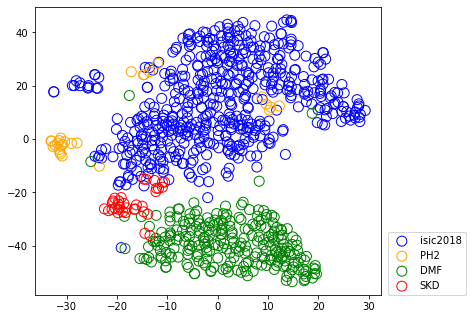

In [22]:
shape = {'isic2018':'o','PH2':'v','DMF':'s','SKD':'D'}
color = {'isic2018':'blue','PH2':'orange','DMF':'green','SKD':'red'}
# initialize a matplotlib plot
fig = plt.figure(figsize=(8,5))
ax = plt.axes([0.05,0.05,0.6,0.8])
# prototypes = model.transform(p_arr)

# 'isic2018','PH2','DMF','SKD'
for label_id, dataset_name in enumerate(['isic2018','PH2','DMF','SKD']):
    indices = [i for i, l in enumerate(new_group_arr) if l == label_id]
    print(len(indices))
    data_tx = np.take(tx, indices)
    data_ty = np.take(ty, indices)
    # ax.scatter(data_tx, data_ty, label=dataset_name, s=20,marker=shape[dataset_name],facecolors='none',edgecolors=color[dataset_name])
    if dataset_name in ['isic2018','PH2','DMF','SKD']:
        ax.scatter(data_tx, data_ty, label=dataset_name, s=100, edgecolors=color[dataset_name],facecolors='none')
        # ax.scatter(data_tx.mean(), data_ty.mean(),label=dataset_name,marker=shape[dataset_name],s=100,color='black')
        # ax.scatter(prototypes[label_id][0], prototypes[label_id][1],label=dataset_name,marker=shape[dataset_name],s=100,color='black')
    # ax.plot()
        
# ax.set_title('TSNE {} Visualization for four datasets'.format(model_name))
# build a legend using the labels we set previously
ax.legend(bbox_to_anchor=(1.02,0), loc=3, borderaxespad=0)
# save_path = '/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/figures/{}_{}_TSNE.jpg'.format('four',model_name)
# plt.savefig(save_path)
# finally, show the plot
plt.show()

In [23]:
# store train and test new domain labels 
fold = 'No'
num_list = [2594, 200, 1212, 206]
dynamic_np = np.zeros((sum(num_list), 4))
dynamic_np[train_four_id_list,0] = train_new_group_arr
dynamic_np[test_four_id_list,0] = test_new_group_arr
dynamic_np_path = '/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/results/dynamic_FATNet/{}_dynamic_info{}.npy'.format(exp_name, fold)
np.save(dynamic_np_path, dynamic_np)

In [24]:
headers = ['label']+['D{}'.format(i) for i in range(dynamic_np.shape[1]-1)]
df = pd.DataFrame(dynamic_np, columns=headers)
df.to_csv('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/results/dynamic_FATNet/{}_dynamic_csv{}.csv'.format(exp_name, fold), index=False)

In [25]:
df['label'].value_counts(ascending=True)

1.0     172
3.0     172
2.0    1227
0.0    2641
Name: label, dtype: int64